In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

%matplotlib inline

### Reading in and examining the heart attack cost disparities data

In [2]:
ha_costs_df = pd.read_csv('../data/mmd_heart_attack_data.csv') 
ha_costs_df.head(2)

,year,geography,measure,adjustment,analysis,domain,condition,primary_sex,primary_age,primary_dual,fips,county,state,urban,primary_race,primary_denominator,analysis_value
0,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,Acute myocardial infarction,All,All,Dual & non-dual,1001,Autauga County,ALABAMA,Urban,All,undefined,40470
1,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,Acute myocardial infarction,All,All,Dual & non-dual,1003,Baldwin County,ALABAMA,Rural,All,undefined,36615


### Now examining the cancer data

In [3]:
cancer_costs_df = pd.read_csv('../data/mmd_cancer_data.csv')
cancer_costs_df.head(2)

,year,geography,measure,adjustment,analysis,domain,condition,primary_sex,primary_age,primary_dual,fips,county,state,urban,primary_race,primary_denominator,analysis_value
0,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,"Cancer, Colorectal, Breast, Prostate, Lung",All,All,Dual & non-dual,1001,Autauga County,ALABAMA,Urban,All,undefined,19293
1,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,"Cancer, Colorectal, Breast, Prostate, Lung",All,All,Dual & non-dual,1003,Baldwin County,ALABAMA,Rural,All,undefined,17151


### Getting the income data and cleaning it a bit

In [4]:
income_df = pd.read_csv('../data/irs_county_2016.csv')
income_df.head(2)

,STATEFIPS,STATE,COUNTYFIPS,COUNTYNAME,agi_stub,N1,mars1,MARS2,MARS4,PREP,...,N10300,A10300,N85530,A85530,N85300,A85300,N11901,A11901,N11902,A11902
0,1,AL,0,Alabama,1,26450,14680,9740,680,17780,...,4300,9256,70,57,0,0,2590,3685,11510,35079
1,1,AL,0,Alabama,2,285760,217880,25170,39740,143390,...,70050,40569,0,0,0,0,22720,11109,237630,263152


In [5]:
income_df = income_df[['STATE', 'COUNTYNAME', 'agi_stub', 'N1', 'mars1', 'MARS2', 'MARS4', 'N2', 'NUMDEP', 'ELDERLY', 'A00100', 'N02650', 'A02650', 'N02300', 'A02300']]
income_df.columns = ['state', 'county', 'income_bucket', 'return_count', 'single_returns', 'joint_returns', 'head_of_house_returns', 'exemptions', 'dependents', 'elderly', 'agi', 'returns_with_total_inc','total_inc_amt', 'returns_with_unemployment', 'unemployment_comp']
income_df.head(2)

,state,county,income_bucket,return_count,single_returns,joint_returns,head_of_house_returns,exemptions,dependents,elderly,agi,returns_with_total_inc,total_inc_amt,returns_with_unemployment,unemployment_comp
0,AL,Alabama,1,26450,14680,9740,680,40700,5590,13000,-1679314,19140,-1657452,60,203
1,AL,Alabama,2,285760,217880,25170,39740,296830,78450,48270,1582247,285760,1632624,4180,10772


#### Creating a new df that aggregates by state and county to get the totals for each county

In [6]:
income_agg = income_df.groupby(['state','county']).agg('sum').reset_index()
income_agg.head(2)

,state,county,income_bucket,return_count,single_returns,joint_returns,head_of_house_returns,exemptions,dependents,elderly,agi,returns_with_total_inc,total_inc_amt,returns_with_unemployment,unemployment_comp
0,AK,Alaska,36,348070,175480,126660,37340,654950,205660,71410,23514361,347600,23858011,83270,167460
1,AK,Aleutians East Borou,36,890,480,230,150,1570,500,160,42834,890,43596,190,466


In [7]:
income_agg['avg_income'] = round(income_agg.total_inc_amt * 1000 / income_agg.returns_with_total_inc, 0)

#### Week 4 Coding Tasks
 - rename `analysis_value` columns in `ha_costs_df` and `cancer_costs_df`
 

In [8]:
ha_costs_df.head(2)

,year,geography,measure,adjustment,analysis,domain,condition,primary_sex,primary_age,primary_dual,fips,county,state,urban,primary_race,primary_denominator,analysis_value
0,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,Acute myocardial infarction,All,All,Dual & non-dual,1001,Autauga County,ALABAMA,Urban,All,undefined,40470
1,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,Acute myocardial infarction,All,All,Dual & non-dual,1003,Baldwin County,ALABAMA,Rural,All,undefined,36615


In [9]:
ha_costs_df = ha_costs_df.rename(columns = {'analysis_value': 'ha_avg_cost'})
ha_costs_df.head(2)

,year,geography,measure,adjustment,analysis,domain,condition,primary_sex,primary_age,primary_dual,fips,county,state,urban,primary_race,primary_denominator,ha_avg_cost
0,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,Acute myocardial infarction,All,All,Dual & non-dual,1001,Autauga County,ALABAMA,Urban,All,undefined,40470
1,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,Acute myocardial infarction,All,All,Dual & non-dual,1003,Baldwin County,ALABAMA,Rural,All,undefined,36615


In [10]:
cancer_costs_df = cancer_costs_df.rename(columns = {'analysis_value': 'cancer_avg_cost'})
cancer_costs_df.head(2)

,year,geography,measure,adjustment,analysis,domain,condition,primary_sex,primary_age,primary_dual,fips,county,state,urban,primary_race,primary_denominator,cancer_avg_cost
0,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,"Cancer, Colorectal, Breast, Prostate, Lung",All,All,Dual & non-dual,1001,Autauga County,ALABAMA,Urban,All,undefined,19293
1,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,"Cancer, Colorectal, Breast, Prostate, Lung",All,All,Dual & non-dual,1003,Baldwin County,ALABAMA,Rural,All,undefined,17151


#### Create a new dataframe  `combined_df` 
- merge `county`, `urban`, and `ha_avg_cost` from `ha_costs_df` with `county` and `cancer_avg_cost` from `cancer_costs_df`


In [11]:
cancer_cost_sub = cancer_costs_df[['state', 'county', 'urban', 'cancer_avg_cost']]
ha_cost_sub = ha_costs_df[['state','county', 'ha_avg_cost']]

In [12]:
combined_df = pd.merge(ha_cost_sub, cancer_cost_sub, on = ['state', 'county'], how = 'inner')
print(combined_df.shape)
combined_df.head(2)

(2656, 5)


,state,county,ha_avg_cost,urban,cancer_avg_cost
0,ALABAMA,Autauga County,40470,Urban,19293
1,ALABAMA,Baldwin County,36615,Rural,17151


#### Now combine all the data and create the cost_income_ratio variables

- merge `avg_income` from `income_agg` with `combined_df` and save back to the `combined_df` variable  

- create `ha_cost_income_ratio` (`ha_avg_cost` / `avg_income`)  

- create `cancer_cost_income_ratio` (`cancer_avg_cost` / `avg_income`)

In [13]:
county_incomes = income_agg[['state','county', 'avg_income']]
county_incomes.head(2)

,state,county,avg_income
0,AK,Alaska,68636.0
1,AK,Aleutians East Borou,48984.0


#### Before you can merge county incomes and combined_df, the data is the `state` columns will need to match

In [14]:
state_abbrev = pd.read_csv('../data/state_abbrev.csv')
state_abbrev.head(3)

,name,abbrev
0,ALABAMA,AL
1,ALASKA,AK
2,ARIZONA,AZ


In [15]:
combined_df['state'] = combined_df.state.map(state_abbrev.set_index('name')['abbrev'].to_dict())
combined_df.head()

,state,county,ha_avg_cost,urban,cancer_avg_cost
0,AL,Autauga County,40470,Urban,19293
1,AL,Baldwin County,36615,Rural,17151
2,AL,Barbour County,46509,Rural,19469
3,AL,Bibb County,42949,Urban,17234
4,AL,Blount County,50067,Urban,20317


In [16]:
combined_df = pd.merge(combined_df, county_incomes, on = ['state', 'county'], how = 'inner')
combined_df.head(2)

,state,county,ha_avg_cost,urban,cancer_avg_cost,avg_income
0,AL,Autauga County,40470,Urban,19293,55843.0
1,AL,Baldwin County,36615,Rural,17151,62832.0


#### What is our target variable? What are the predictor variables?
- The target is whether or not `cancer_avg_cost` is above or below the mean. 
- Predictors are `ha_avg_cost`, `urban`, and `avg_income`

In [17]:
avg_cancer_cost = combined_df.cancer_avg_cost.mean()

In [18]:
combined_df.cancer_avg_cost.isnull().sum()

0

In [19]:
above_below_list = []
for value in combined_df.cancer_avg_cost:
    if value > avg_cancer_cost:
        above_below_list.append(1)
    else:
        above_below_list.append(0)

In [20]:
above_below_list[0:10]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1]

In [21]:
combined_df['above_avg_cancer_cost'] = above_below_list
combined_df.head()

,state,county,ha_avg_cost,urban,cancer_avg_cost,avg_income,above_avg_cancer_cost
0,AL,Autauga County,40470,Urban,19293,55843.0,0
1,AL,Baldwin County,36615,Rural,17151,62832.0,0
2,AL,Barbour County,46509,Rural,19469,40269.0,0
3,AL,Bibb County,42949,Urban,17234,47380.0,0
4,AL,Blount County,50067,Urban,20317,49535.0,0


In [22]:
avg_cancer_cost

20539.590683466973

In [23]:
combined_df = pd.get_dummies(combined_df, columns = ['urban'], drop_first = True)
combined_df.head(3)

,state,county,ha_avg_cost,cancer_avg_cost,avg_income,above_avg_cancer_cost,urban_Urban
0,AL,Autauga County,40470,19293,55843.0,0,1
1,AL,Baldwin County,36615,17151,62832.0,0,0
2,AL,Barbour County,46509,19469,40269.0,0,0


In [24]:
X = combined_df[['ha_avg_cost', 'avg_income', 'urban_Urban']]
y = combined_df.above_avg_cancer_cost

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2020)

#### Scaling our predictors will help them look more like normally distributed data

In [26]:
scaler = StandardScaler()

In [27]:
X_train = scaler.fit_transform(X_train)

In [28]:
X_train

array([[-0.87394627, -0.23899838, -0.80476767],
       [-1.33234143, -1.09925666, -0.80476767],
       [ 0.86612468,  0.09015388,  1.24259464],
       ...,
       [ 0.11347041, -0.256457  , -0.80476767],
       [-0.278355  ,  0.42921508,  1.24259464],
       [-0.43833044, -0.55419723, -0.80476767]])

In [29]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression()

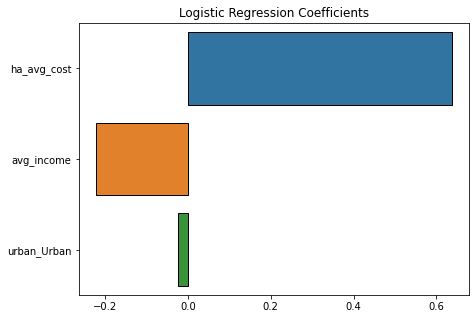

In [30]:
fig, ax = plt.subplots(figsize = (7,5))
sns.barplot(x = logistic_model.coef_[0], y = list(X.columns), ax = ax, edgecolor = 'black')
plt.title('Logistic Regression Coefficients');

#### Before using the model to predict with the test data, transform `X_test` with the scaler

In [31]:
X_test = scaler.fit_transform(X_test)

In [32]:
y_pred = logistic_model.predict(X_test)

In [33]:
print(metrics.accuracy_score(y_test, y_pred))

0.6320610687022901


In [34]:
y_test.value_counts(normalize = True)

0    0.540458
1    0.459542
Name: above_avg_cancer_cost, dtype: float64

#### Our model is a bit better than the naive model

In [35]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.77      0.69       354
           1       0.64      0.47      0.54       301

    accuracy                           0.63       655
   macro avg       0.63      0.62      0.62       655
weighted avg       0.63      0.63      0.62       655



#### Let's check AUC

In [36]:
y_pred_prob = logistic_model.predict_proba(X_test)[:,1]

In [37]:
print(metrics.roc_auc_score(y_test, y_pred_prob))

0.7084295286896785


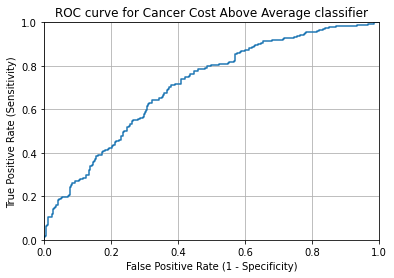

In [38]:
fp_rate, tp_rate, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot(fp_rate, tp_rate)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Cancer Cost Above Average classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)